# Andrew Pitts
## EPS 109 Final Presentation

The animations presented were created with the use of a package called Photutils, which is a package containing many useful tools for astronomical calculations. While this package is not necessary to detect the transit (as shown in cells 4-5), I decided to use it for the animation as the tools are more aesthetically and scientifically pleasing.


Cells 6 and beyond will require Photutils

To install Photutils use either pip or conda installation with these commands

`pip install photutils`

`conda install -c conda-forge photutils`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
star = np.load('HATP All Images.npy') # load in the images (3D array)

Text(0.7075, 0.325, 'TYC 3281-957-1')

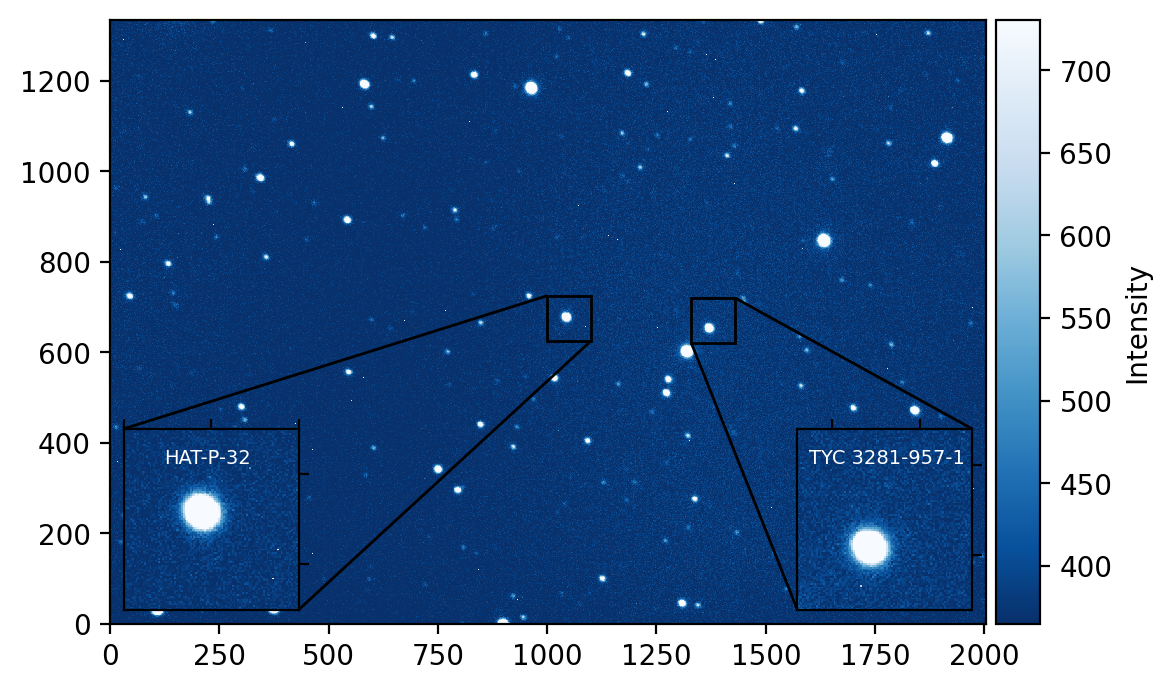

In [3]:
# Make a nice looking picture for the slides!
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

lo = np.percentile(star[0],50)
hi = np.percentile(star[0],99.75)

fig, ax = plt.subplots(dpi=200)
im = ax.pcolormesh(star[0],vmin=lo,vmax=hi,cmap='Blues_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical',label='Intensity')

axins = zoomed_inset_axes(ax, zoom=4, loc=3)
axins.pcolormesh(star[0],vmin=lo, vmax=hi,cmap='Blues_r')

x1, x2, y1, y2 = 1000, 1100, 625, 725
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.xaxis.tick_top()
axins.yaxis.tick_right()
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black")

axins2 = zoomed_inset_axes(ax, zoom=4, loc=4)
axins2.pcolormesh(star[0],vmin=lo, vmax=hi,cmap='Blues_r')

x3, x4, y3, y4 = 1330, 1430, 620, 720
axins2.set_xlim(x3, x4)
axins2.set_ylim(y3, y4)
axins2.xaxis.tick_top()
axins2.yaxis.tick_right()
plt.setp(axins2.get_xticklabels(), visible=False)
plt.setp(axins2.get_yticklabels(), visible=False)
mark_inset(ax, axins2, loc1=1, loc2=3, fc="none", ec="black")

fig.text(0.17,0.325,'HAT-P-32',color='white',fontsize=7)
fig.text(0.7075,0.325,'TYC 3281-957-1',color='white',fontsize=7)


#fig.savefig('Skymap.png',bbox_inches='tight')

In [4]:
# We can obtain the lightcurve with no packages
hatp=np.zeros(star.shape[0])
tyc=np.zeros(star.shape[0])
rel=np.zeros(star.shape[0])

box_size=30
l = box_size//2

dx=0
dy=0
x1 = 1075
x2 = 975
y1 = 725
y2 = 625

xx1 = 1440
xx2 = 1350
yy1 = 700
yy2 = 600
for i in range(0,star.shape[0]):
        image=star[i]
        image1=star[i][y2+dy:y1+dy,x2-dx:x1-dx]
        image2=star[i][yy2+dy:yy1+dy,xx2-dx:xx1-dx]
        
        for x in range(x2-dx,x1-dx):
            for y in range(y2+dy,y1+dy):
                if image[y,x]==image1.max():
                    hatpx = x
                    hatpy = y
        for x in range(xx2-dx,xx1-dx):
            for y in range(yy2+dy,yy1+dy):
                if image[y,x]==image2.max():
                    tycx = x
                    tycy = y
                    
        median = np.median(image) # can estimate the background as the median of the whole image
        bkg = median * (box_size**2)
        
        # hatp
        hatp_signal = np.sum(star[i][hatpy-l:hatpy+l,hatpx-l:hatpx+l]) - bkg
        
        # tyc
        tyc_signal = np.sum(star[i][tycy-l:tycy+l,tycx-l:tycx+l]) - bkg
        
        hatp[i] = hatp_signal
        tyc[i] = tyc_signal
        
        rel[i] = hatp_signal/tyc_signal
        
        dy+=2
        if i%2==0:
            dx+=3

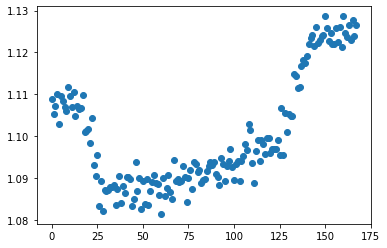

In [5]:
plt.plot(rel,'o')

**The following cells require Photutils**

In [6]:
import photutils
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry

In [7]:
# repeat the light curve (pretty much same exact code, just use circular apertures to sum the counts instead of box)
hatp=np.zeros(star.shape[0])
tyc=np.zeros(star.shape[0])
rel=np.zeros(star.shape[0])
error=np.zeros(star.shape[0])
dx=0
dy=0
x1 = 1075
x2 = 975
y1 = 725
y2 = 625

xx1 = 1440
xx2 = 1350
yy1 = 700
yy2 = 600
for i in range(0,star.shape[0]):
        image=star[i]
        image1=star[i][y2+dy:y1+dy,x2-dx:x1-dx]
        image2=star[i][yy2+dy:yy1+dy,xx2-dx:xx1-dx]
        lo = np.percentile(image,50)
        hi = np.percentile(image,99.75)
        
        for x in range(x2-dx,x1-dx):
            for y in range(y2+dy,y1+dy):
                if image[y,x]==image1.max():
                    hatpx = x
                    hatpy = y
        for x in range(xx2-dx,xx1-dx):
            for y in range(yy2+dy,yy1+dy):
                if image[y,x]==image2.max():
                    tycx = x
                    tycy = y

        positions=[(hatpx,hatpy),(tycx,tycy)]
        aperture=CircularAperture(positions,r=12)
        annulus=CircularAnnulus(positions,r_in=15,r_out=20)
        apertures=[aperture,annulus]
        phot_table=aperture_photometry(image,apertures)
        
        # hatp
        bkg_mean = (phot_table['aperture_sum_1'][0])/annulus.area
        bkg_sum = bkg_mean * aperture.area
        
        hatp_signal = phot_table['aperture_sum_0'][0] - bkg_sum
        
        # tyc
        bkg_mean_tyc = (phot_table['aperture_sum_1'][1])/annulus.area
        bkg_sum_tyc = bkg_mean_tyc * aperture.area
        
        tyc_signal = phot_table['aperture_sum_0'][1] - bkg_sum_tyc
        
        # noise
        noise = np.sqrt(hatp_signal + tyc_signal + bkg_sum)
        
        hatp[i] = hatp_signal
        tyc[i] = tyc_signal
        
        error[i] = noise/tyc_signal       
        rel[i] = hatp_signal/tyc_signal
        
        dy+=2
        if i%2==0:
            dx+=3

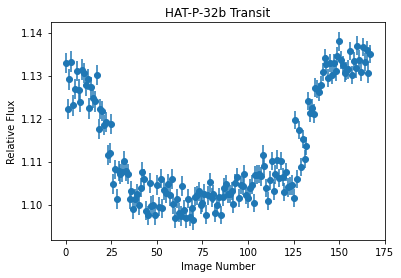

In [8]:
imagenum=range(star.shape[0])
plt.errorbar(x=imagenum,y=rel,yerr=error,fmt='o')
plt.xlabel('Image Number')
plt.ylabel('Relative Flux')
plt.title('HAT-P-32b Transit')
plt.show()

In [9]:
# Make the animations! 

In [10]:
from matplotlib.animation import FFMpegWriter

In [11]:
plt.rcParams['animation.ffmpeg_path']=r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'

In [12]:
# Animating tracking the stars across the images with the apertures

%matplotlib qt
dx=0
dy=0
x1 = 1075
x2 = 975
y1 = 725
y2 = 625

xx1 = 1440
xx2 = 1350
yy1 = 700
yy2 = 600

metadata = dict(title='HATP32 Skymap',artist='Andrew Pitts',comment='_')
writer = FFMpegWriter(fps=15,metadata=metadata)
fig = plt.figure()

filename='Final HATP32 Sky 15fps.mp4'
with writer.saving(fig,filename,dpi=200):
    for i in range(0,star.shape[0]):
        image=star[i]
        image1=star[i][y2+dy:y1+dy,x2-dx:x1-dx]
        image2=star[i][yy2+dy:yy1+dy,xx2-dx:xx1-dx]
        lo = np.percentile(image,50)
        hi = np.percentile(image,99.75)

        for x in range(x2-dx,x1-dx):
            for y in range(y2+dy,y1+dy):
                if image[y,x]==image1.max():
                    hatpx = x
                    hatpy = y
        for x in range(xx2-dx,xx1-dx):
            for y in range(yy2+dy,yy1+dy):
                if image[y,x]==image2.max():
                    tycx = x
                    tycy = y

        positions=[(hatpx,hatpy),(tycx,tycy)]
        aperture=CircularAperture(positions,r=20) # expand the aperture radii to make them look better in the image
        annulus=CircularAnnulus(positions,r_in=30,r_out=40)
        plt.clf()
        plt.imshow(image,vmin=lo,vmax=hi,cmap='Blues_r',origin='lower')
        plt.axis('off')
        aperture.plot(color='red',lw=1)
        annulus.plot(color='black',lw=1)
        plt.tight_layout()
        plt.show()
        plt.draw()
        plt.pause(0.05)
        writer.grab_frame()

        dy+=2
        if i%2==0:
            dx+=3

In [13]:
%matplotlib inline

In [14]:
# Animating the generation of the light curve

style = dict(
    
    
    linestyle='none',
    marker='o',
    ms=4,
    lw=1,
    markerfacecolor='crimson',
    markeredgecolor='k',
    markeredgewidth=0.6,
    
    ecolor='k',
    elinewidth=0.5,
    capsize=1,
    #label='data'
)    

hatp=np.zeros(star.shape[0])
tyc=np.zeros(star.shape[0])
rel=np.zeros(star.shape[0])
error=np.zeros(star.shape[0])
imagenum=range(star.shape[0])
g=np.linspace(0,1,4)

dx=0
dy=0
x1 = 1075
x2 = 975
y1 = 725
y2 = 625

xx1 = 1440
xx2 = 1350
yy1 = 700
yy2 = 600

%matplotlib qt
metadata = dict(title='HATP32 Lightcurve',artist='Andrew Pitts',comment='_')
writer = FFMpegWriter(fps=60,metadata=metadata)
fig2 = plt.figure()

filename='Final HATP32 Lightcurve 60fps.mp4'
with writer.saving(fig2,filename,dpi=200):
    for i in range(0,star.shape[0]):
            image=star[i]
            image1=star[i][y2+dy:y1+dy,x2-dx:x1-dx]
            image2=star[i][yy2+dy:yy1+dy,xx2-dx:xx1-dx]

            for x in range(x2-dx,x1-dx):
                for y in range(y2+dy,y1+dy):
                    if image[y,x]==image1.max():
                        hatpx = x
                        hatpy = y
            for x in range(xx2-dx,xx1-dx):
                for y in range(yy2+dy,yy1+dy):
                    if image[y,x]==image2.max():
                        tycx = x
                        tycy = y

            positions=[(hatpx,hatpy),(tycx,tycy)]
            aperture=CircularAperture(positions,r=12)
            annulus=CircularAnnulus(positions,r_in=15,r_out=20)
            apertures=[aperture,annulus]
            phot_table=aperture_photometry(image,apertures)

            # hatp
            bkg_mean = (phot_table['aperture_sum_1'][0]*1.6)/annulus.area
            bkg_sum = bkg_mean * aperture.area

            hatp_signal = phot_table['aperture_sum_0'][0]*1.6 - bkg_sum

            # tyc
            bkg_mean_tyc = (phot_table['aperture_sum_1'][1]*1.6)/annulus.area
            bkg_sum_tyc = bkg_mean_tyc * aperture.area

            tyc_signal = phot_table['aperture_sum_0'][1]*1.6 - bkg_sum_tyc
            
            #noise
            uncertainty = np.sqrt(hatp_signal + tyc_signal + bkg_sum)

            hatp[i] = hatp_signal
            tyc[i] = tyc_signal
            error[i] = uncertainty/tyc_signal
            rel[i] = hatp_signal/tyc_signal
            value = error[i]
            
            for z in range(4): #Form the error bars, looks nicer
                error[i]=value*g[z]
                plt.clf()
                plt.errorbar(x=imagenum,y=rel,yerr=error,**style)
                plt.ylim(1.09,1.14)
                plt.xlim(0,star.shape[0])
                plt.xlabel('Image Number')
                plt.ylabel('Relative Flux')
                plt.title('HAT-P-32b Transit')
                plt.show()
                plt.draw()
                plt.pause(0.05)
                writer.grab_frame()

            dy+=2
            if i%2==0:
                dx+=3